In [3]:
# ===============================================
# MNIST Image Processing & Analysis Assignment
# Framework: Google Colab
# Dataset: MNIST Handwritten Digits
# Algorithms: KMeans Clustering (unsupervised), Logistic Regression (supervised)
# ===============================================

In [4]:
# -----------------------------
# 1️⃣ Install / Import Libraries
# -----------------------------
# Google Colab usually has these pre-installed
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow as tf

In [5]:
# -----------------------------
# 2️⃣ Load MNIST Dataset
# -----------------------------
# MNIST comes preloaded with TensorFlow
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print("Training set shape:", x_train.shape)
print("Test set shape:", x_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training set shape: (60000, 28, 28)
Test set shape: (10000, 28, 28)


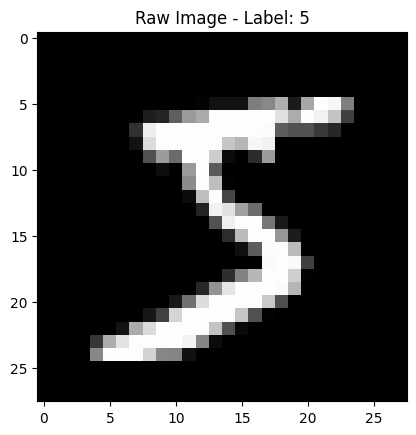

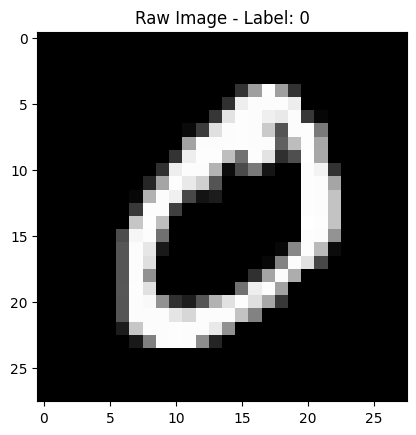

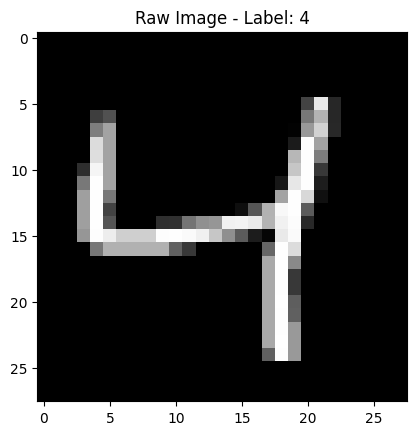

In [6]:
# -----------------------------
# 3️⃣ Show Example of Raw Data
# -----------------------------
# Display first 3 raw images
for i in range(3):
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Raw Image - Label: {y_train[i]}")
    plt.show()

In [7]:
# -----------------------------
# 4️⃣ Preprocessing (Handling Unstructured Data)
# -----------------------------
# Normalize pixel values to 0-1
x_train_norm = x_train / 255.0
x_test_norm = x_test / 255.0

# Flatten images for ML algorithms (28x28 -> 784 features)
x_train_flat = x_train_norm.reshape(len(x_train_norm), -1)
x_test_flat = x_test_norm.reshape(len(x_test_norm), -1)

print("Example of processed vector (first 10 features):")
print(x_train_flat[0][:10])

Example of processed vector (first 10 features):
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [8]:
# -----------------------------
# 5️⃣ Unsupervised Learning: KMeans Clustering
# -----------------------------
# Cluster MNIST images into 10 clusters (digits 0-9)
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(x_train_flat)

KMeans(n_clusters=10, random_state=42)

In [9]:
# Cluster assignments
clusters = kmeans.labels_

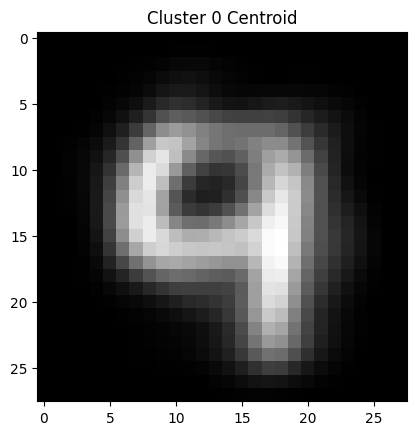

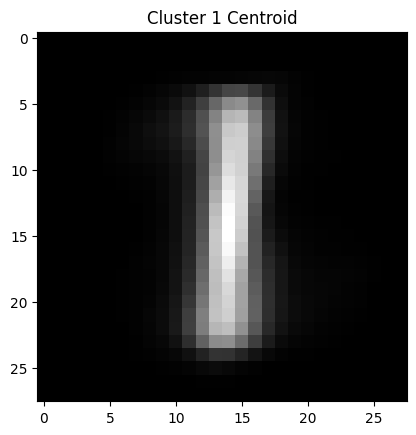

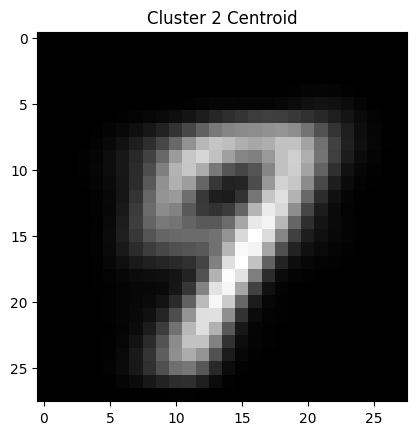

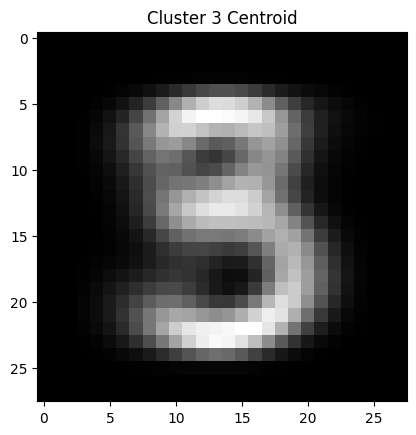

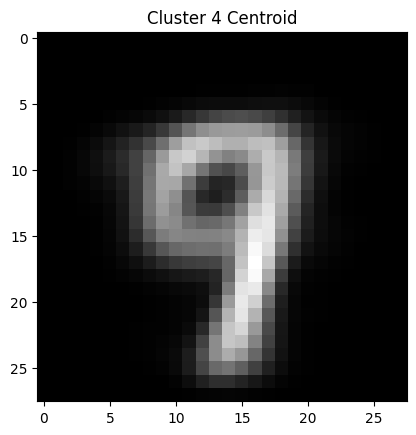

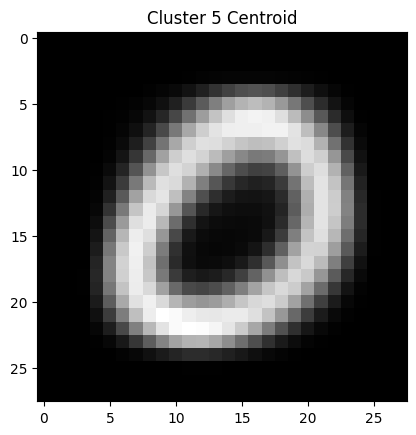

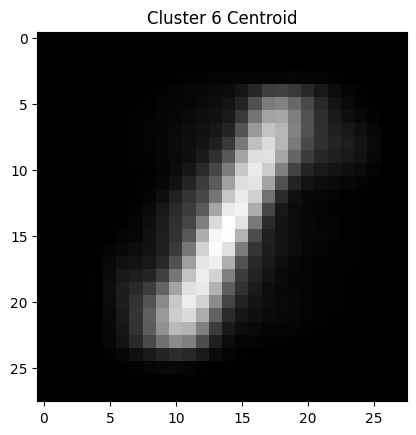

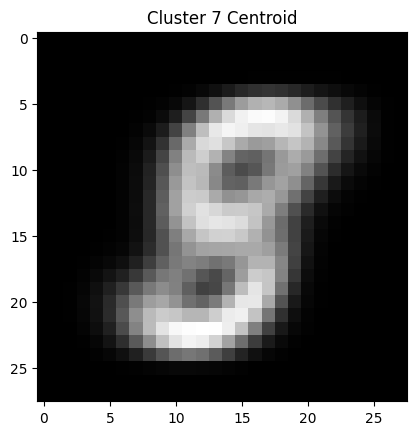

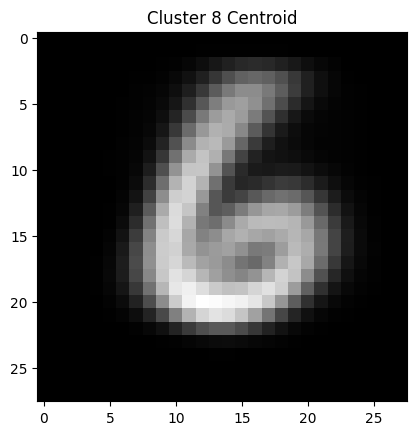

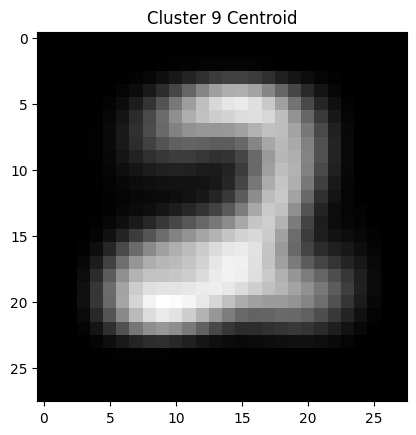

In [10]:
# -----------------------------
# 5a️⃣ Show Cluster Centroids as Images
# -----------------------------
for i in range(10):
    centroid = kmeans.cluster_centers_[i].reshape(28,28)
    plt.imshow(centroid, cmap='gray')
    plt.title(f"Cluster {i} Centroid")
    plt.show()

In [11]:
# -----------------------------
# 5b️⃣ Map Clusters to Actual Digits (Insight)
# -----------------------------
# Count which label appears most in each cluster
cluster_label_mapping = {}
for i in range(10):
    indices = np.where(clusters == i)[0]
    most_common_label = np.bincount(y_train[indices]).argmax()
    cluster_label_mapping[i] = most_common_label
    print(f"Cluster {i} mostly contains digit: {most_common_label}")

Cluster 0 mostly contains digit: 4
Cluster 1 mostly contains digit: 1
Cluster 2 mostly contains digit: 7
Cluster 3 mostly contains digit: 3
Cluster 4 mostly contains digit: 9
Cluster 5 mostly contains digit: 0
Cluster 6 mostly contains digit: 1
Cluster 7 mostly contains digit: 8
Cluster 8 mostly contains digit: 6
Cluster 9 mostly contains digit: 2


In [12]:
# -----------------------------
# 6️⃣ Supervised Learning: Logistic Regression
# -----------------------------
# Logistic Regression classifier on flattened features
lr = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='auto')
lr.fit(x_train_flat, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='auto')

In [13]:
# Predict on test set
y_pred = lr.predict(x_test_flat)

In [14]:
# -----------------------------
# 6a️⃣ Evaluate Model
# -----------------------------
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy*100:.2f}%")

Logistic Regression Accuracy: 92.59%


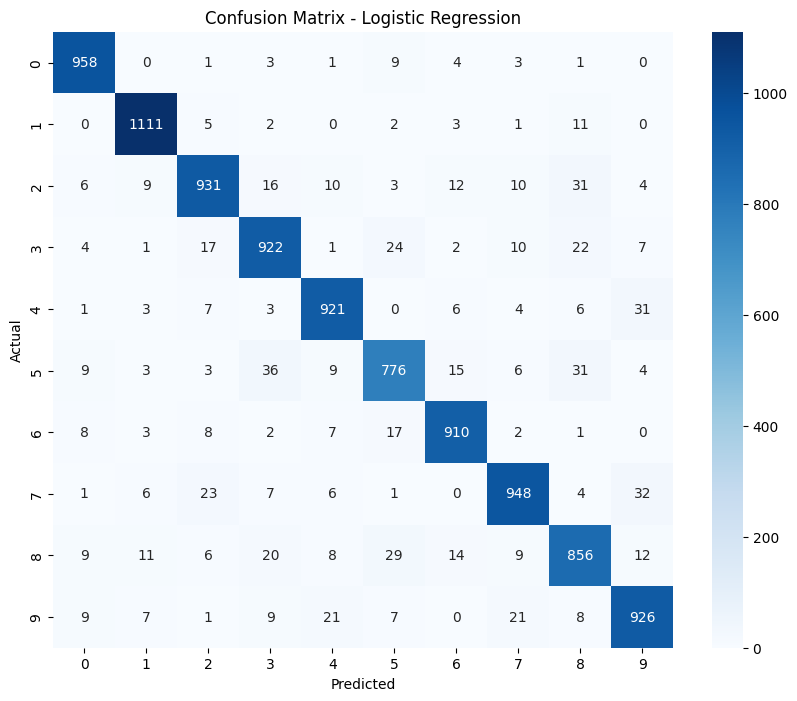

In [15]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

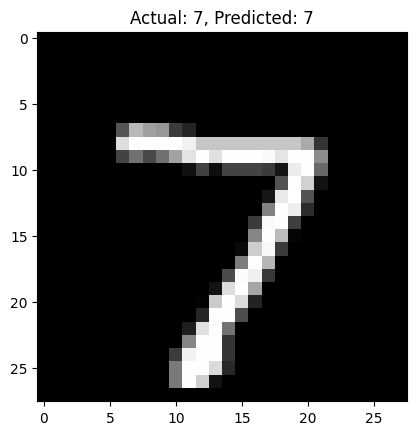

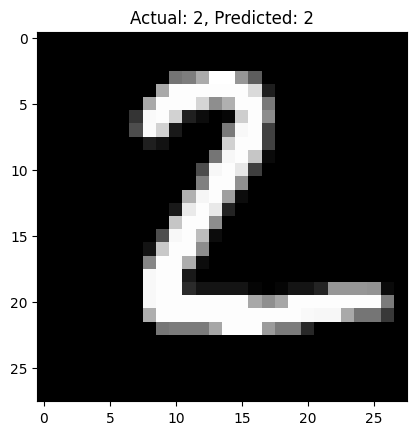

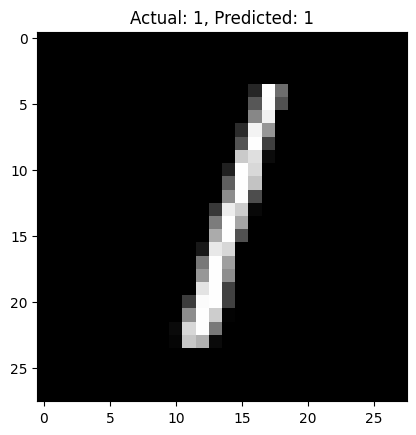

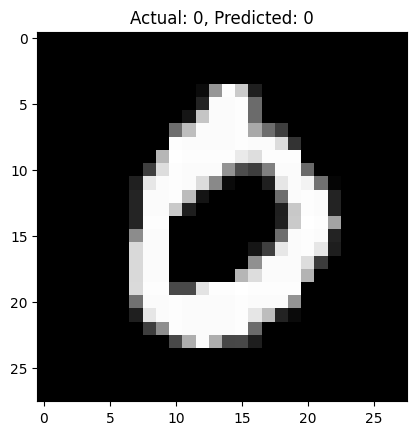

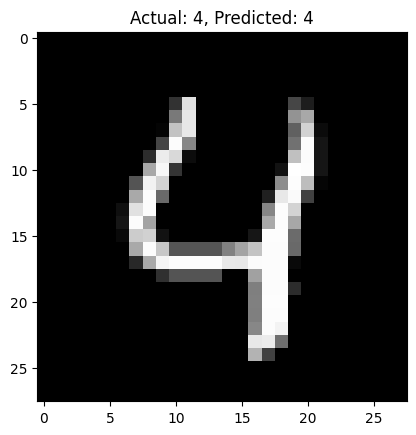

In [17]:
# -----------------------------
# 7️⃣ Some Predictions vs Actual
# -----------------------------
for i in range(5):
    plt.imshow(x_test[i], cmap='gray')
    plt.title(f"Actual: {y_test[i]}, Predicted: {y_pred[i]}")
    plt.show()